# function store

In [336]:
def _classification_report(prediction , nameOfModel) : 
    #PREPARE SECCTION
    target_names = df_label["sleep"].unique().sort()
    clf_rbf_raw = classification_report(y_test,prediction ,target_names=target_names  ,output_dict=True)
    clf_rbf = pd.DataFrame(clf_rbf_raw)
    
    #PLOTING SECCTION
    fig = px.imshow(clf_rbf.iloc[:-1, :].T, text_auto=True ,aspect="auto",color_continuous_scale='GnBu'  )
    fig.update_layout(height=400, width=500, title_text='Classification Report of '+str(nameOfModel) +"SVM")
    fig.show()

# import lib

In [337]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import  GridSearchCV ,RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

# (a) Load and Prepare Data

In [338]:
# Load data from csv 3 files
# acceleration.txt, heartrate.txt, labeled_sleep.txt
acceleration = "./Resources/46343_acceleration.txt"
heartrate = "./Resources/46343_heartrate.txt"
labeled_sleep="./Resources/46343_labeled_sleep.txt"
init_acc = pd.read_csv(acceleration, sep = ' ',names=['timedelta', 'accX', 'accY', 'accZ'])
init_heartrate = pd.read_csv(heartrate, sep = ',',names=['timedelta', 'heartrate'])
init_sleep = pd.read_csv(labeled_sleep, sep = ' ',names=['timedelta', 'sleep'])

In [339]:
init_acc.head()

,timedelta,accX,accY,accZ
0,-124489.161050,0.017487,-0.586700,-0.805771
1,-124489.116395,0.018982,-0.589676,-0.809158
2,-124489.115548,0.020966,-0.580887,-0.815048
3,-124489.114691,0.019485,-0.580872,-0.813583
4,-124489.097700,0.016998,-0.587204,-0.806259


In [340]:
init_heartrate.head()

,timedelta,heartrate
0,-556410.36066,57
1,-556408.36062,56
2,-556403.36062,56
3,-556399.36062,57
4,-556389.36062,59


In [341]:
init_sleep.head()

,timedelta,sleep
0,0,-1
1,30,-1
2,60,-1
3,90,-1
4,120,-1


In [342]:
acc_max_date = init_acc["timedelta"].max()
acc_min_date = init_acc["timedelta"].min()
print("acceleration start :" ,acc_min_date)
print("acceleration end :" ,acc_max_date)

acceleration start : -124489.16105
acceleration end : 17643.046417


In [343]:
sleep_min = init_sleep["timedelta"].min()
sleep_max = init_sleep["timedelta"].max()
print("sleep label start :" ,sleep_min)
print("sleep label end :" ,sleep_max)

sleep label start : 0
sleep label end : 16980


In [344]:
hrate_min = init_heartrate["timedelta"].min()
hrate_max = init_heartrate["timedelta"].max()
print("heart rate start :" ,hrate_min)
print("heart rate end :" ,hrate_max)

heart rate start : -556410.36066
heart rate end : 16980.47229


### select only intersected timedelta (ACC, HeartR, SleepL) (ช่วงเวลาที่มีข้อมูลใกล้กัน)

In [345]:
seleted_min  = 100
seleted_max = 5000

In [346]:
acc_new = init_acc[(init_acc['timedelta'] > seleted_min ) & (init_acc['timedelta'] <= seleted_max)]
heartRate_new = init_heartrate[(init_heartrate['timedelta'] >= seleted_min ) & (init_heartrate['timedelta'] < seleted_max)]
sleepLabel_new = init_sleep[(init_sleep['timedelta'] >= seleted_min ) &(init_sleep['timedelta'] <= seleted_max)]

# Convert to datetime and round to second,

In [347]:
acc_new["timedelta"] = pd.DataFrame(pd.to_timedelta(acc_new['timedelta'], unit='s').round('1s'))

# Average rounding duplicated time

In [348]:
df_acc_X = acc_new.groupby('timedelta')['accX'].mean().reset_index()
df_acc_Y = acc_new.groupby('timedelta')['accY'].mean().reset_index()
df_acc_Z = acc_new.groupby('timedelta')['accZ'].mean().reset_index()

In [349]:
acc_df = df_acc_X.set_index('timedelta').join(df_acc_Y.set_index('timedelta')).join(df_acc_Z.set_index('timedelta'))

In [350]:
acc_df.head()

,accX,accY,accZ
timedelta,,,
0 days 00:01:40,-0.376241,0.925141,-0.008848
0 days 00:01:41,-0.377814,0.925636,0.003382
0 days 00:01:42,-0.379298,0.924588,0.003643
0 days 00:01:43,-0.379019,0.925039,0.000995
0 days 00:01:44,-0.380270,0.924537,-0.000302


# (c) Load and Prepare Data (Heart rate)

In [351]:
heartRate_new["timedelta"] = pd.DataFrame(pd.to_timedelta(heartRate_new['timedelta'], unit='s').round('1s'))

In [352]:
# Group duplicate time
df_acc_X = heartRate_new.groupby('timedelta')['heartrate'].mean().reset_index()

In [353]:
resample_rule = '1s'
heartrate_df = heartRate_new.set_index('timedelta').resample(resample_rule,).median().ffill()

In [354]:
# map วินาทีของ heartrate ที่หายไป ส่งผลให้ timedelta มีช่วงเวลาครบตามที่เรากำหนด
heartrate_df

,heartrate
timedelta,
0 days 00:01:40,83.0
0 days 00:01:41,83.0
0 days 00:01:42,83.0
0 days 00:01:43,83.0
0 days 00:01:44,83.0
...,...
0 days 01:23:12,95.0
0 days 01:23:13,95.0
0 days 01:23:14,95.0


# (c) Load and Prepare Data (Sleep Label)

In [355]:
sleepLabel_new["timedelta"] = pd.DataFrame(pd.to_timedelta(sleepLabel_new['timedelta'], unit='s').round('1s'))

In [356]:
sleeplabel_df = sleepLabel_new.set_index('timedelta').resample(resample_rule,).median().ffill()
sleeplabel_df

,sleep
timedelta,
0 days 00:02:00,-1.0
0 days 00:02:01,-1.0
0 days 00:02:02,-1.0
0 days 00:02:03,-1.0
0 days 00:02:04,-1.0
...,...
0 days 01:22:56,5.0
0 days 01:22:57,5.0
0 days 01:22:58,5.0


# ( e) Merge Data and Standardized data

In [357]:
df = []
df = pd.merge_asof(acc_df, heartrate_df, on='timedelta')
df = pd.merge_asof(df, sleeplabel_df, on='timedelta')

In [358]:
df

,timedelta,accX,accY,accZ,heartrate,sleep
0,0 days 00:01:40,-0.376241,0.925141,-0.008848,83.0,NaN
1,0 days 00:01:41,-0.377814,0.925636,0.003382,83.0,NaN
2,0 days 00:01:42,-0.379298,0.924588,0.003643,83.0,NaN
3,0 days 00:01:43,-0.379019,0.925039,0.000995,83.0,NaN
4,0 days 00:01:44,-0.380270,0.924537,-0.000302,83.0,NaN
...,...,...,...,...,...,...
4896,0 days 01:23:16,0.475862,-0.153555,-0.866447,99.0,5.0
4897,0 days 01:23:17,0.482310,-0.151454,-0.863023,99.0,5.0
4898,0 days 01:23:18,0.484474,-0.150245,-0.861839,99.0,5.0
4899,0 days 01:23:19,0.477683,-0.152877,-0.865124,99.0,5.0


In [359]:
df.isnull().sum()

timedelta     0
accX          0
accY          0
accZ          0
heartrate     0
sleep        20
dtype: int64

# fill na sleep data wth 0

In [360]:
df['sleep'] = df["sleep"].fillna(value=0)
df['heartrate'] = df["heartrate"].fillna(df['heartrate'].median())

In [361]:
df

,timedelta,accX,accY,accZ,heartrate,sleep
0,0 days 00:01:40,-0.376241,0.925141,-0.008848,83.0,0.0
1,0 days 00:01:41,-0.377814,0.925636,0.003382,83.0,0.0
2,0 days 00:01:42,-0.379298,0.924588,0.003643,83.0,0.0
3,0 days 00:01:43,-0.379019,0.925039,0.000995,83.0,0.0
4,0 days 00:01:44,-0.380270,0.924537,-0.000302,83.0,0.0
...,...,...,...,...,...,...
4896,0 days 01:23:16,0.475862,-0.153555,-0.866447,99.0,5.0
4897,0 days 01:23:17,0.482310,-0.151454,-0.863023,99.0,5.0
4898,0 days 01:23:18,0.484474,-0.150245,-0.861839,99.0,5.0
4899,0 days 01:23:19,0.477683,-0.152877,-0.865124,99.0,5.0


# Standardized data

In [362]:
# Standardized data
feature_columns = ['accX', 'accY', 'accZ', 'heartrate']
label_columns = ['sleep']
df_feature = df[feature_columns]
df_label = df[label_columns]

In [363]:
std = StandardScaler()

In [364]:
norm_value = std.fit_transform(df_feature)

In [365]:
norm_df = pd.DataFrame(norm_value ,columns=feature_columns)

In [366]:
norm_df

,accX,accY,accZ,heartrate
0,-0.852123,4.752143,-0.864542,-0.576831
1,-0.858161,4.754342,-0.846914,-0.576831
2,-0.863857,4.749688,-0.846537,-0.576831
3,-0.862788,4.751690,-0.850354,-0.576831
4,-0.867589,4.749463,-0.852223,-0.576831
...,...,...,...,...
4896,2.419082,-0.035614,-2.100713,3.389565
4897,2.443837,-0.026287,-2.095778,3.389565
4898,2.452144,-0.020924,-2.094071,3.389565
4899,2.426073,-0.032603,-2.098807,3.389565


In [367]:
import plotly.express as px
from plotly.subplots import make_subplots
fig = make_subplots(rows=2, cols=1)
for i in range(len(feature_columns)) :
    fig.add_trace(
        go.Scatter(
            name=feature_columns[i],
            x=norm_df.index,
            y=norm_df[feature_columns[i]],
            showlegend=True),
         row=1, col=1
    )
fig.add_trace(
        go.Scatter(
            name="sleep",
            x=df_label.index,
            y=df_label["sleep"],
            showlegend=True),
     row=2, col=1)
fig.update_layout(height=900, width=1000, title_text="Visualization")

fig.show()

# MODEL PREPARATION

In [368]:
Rseed = 40
x_train, x_test, y_train, y_test = train_test_split(norm_df, df_label, test_size = 0.33, random_state = Rseed)

In [369]:
x_train

,accX,accY,accZ,heartrate
3255,-0.439032,0.106491,0.522891,0.166868
46,-0.952809,4.700771,-0.771705,-0.328931
1858,-0.425199,-0.275487,0.499415,-0.576831
2099,-0.432755,-0.259785,0.500055,-0.328931
2421,-0.427972,-0.143114,0.509031,-0.081031
...,...,...,...,...
3603,-0.109086,-0.206471,0.533202,3.389565
4722,2.440643,-0.031927,-2.096196,-0.081031
3340,-0.438725,0.110862,0.521503,0.414768
3064,-0.440594,0.093788,0.522333,0.166868


In [370]:
c_val = 100 
gmm =0.1
d = 2

In [371]:
# Model initialize
svc_lin = SVC(kernel='linear', C=c_val)
svc_rbf = SVC(kernel='rbf', C=c_val, gamma=gmm)
svc_poly = SVC(kernel='poly', C=c_val, degree = d)

In [372]:
svc_lin.fit(x_train , y_train)
svc_rbf.fit(x_train , y_train)
svc_poly.fit(x_train , y_train)

SVC(C=100, degree=2, kernel='poly')

In [373]:
svc_rbf_pred = svc_rbf.predict(x_test)
linear_predict = svc_lin.predict(x_test)
poly_predict = svc_poly.predict(x_test)

# Visaulize Section

In [374]:
from sklearn.metrics import plot_confusion_matrix

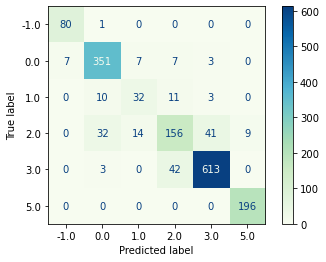

In [375]:
plot_confusion_matrix(svc_rbf, x_test, y_test ,cmap="GnBu")  
plt.show()
_classification_report(svc_rbf_pred ,"RBF" )


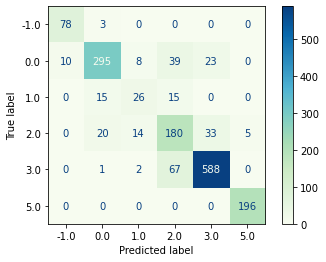

In [335]:
plot_confusion_matrix(svc_lin, x_test, y_test ,cmap="GnBu")  
plt.show()
_classification_report(linear_predict ,"Linear")

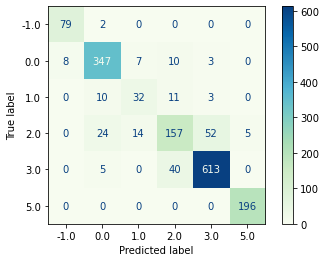

In [376]:
plot_confusion_matrix(svc_poly, x_test, y_test ,cmap="GnBu")  
plt.show()
_classification_report(poly_predict ,"Poly")

## Prepare Parameter Dictionary and Linear Regression() , SVR() with GridSearchCV() 


In [377]:
kernel = ['linear', 'rbf', 'poly']
C_list = [0.1, 1.0, 10.0, 100.0, 200.0, 500.0]
Gamma_list = [0.01, 0.1, 1.0, 10]
degree = [2, 3]
params = dict( kernel = kernel, C = C_list, gamma = Gamma_list, degree = degree )

In [378]:
grid = GridSearchCV( estimator=SVC(), 
                    n_jobs = -1,
                    verbose = 10,
                    cv = 2,
                    scoring = "accuracy",
                   param_grid = params )

In [ ]:
result = grid.fit(x_train , y_train)

Fitting 2 folds for each of 144 candidates, totalling 288 fits
